In [165]:
#imports
import numpy as np
import pandas as pd
import lasio 
from las_py import Laspy
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from matplotlib.colors import ListedColormap

In [16]:
las = lasio.read("./data/100163203803W400.las")
mnemonic = las.keys()
print(mnemonic)

['DEPTH', 'GR', 'NPHI', 'PE', 'RHOB', 'AC']


In [149]:
data = np.loadtxt('./data/100163203803W400.las', skiprows=52)

data = pd.DataFrame(data, columns=mnemonic)

data.head(10)

,DEPTH,GR,NPHI,PE,RHOB,AC
0,770.80,68.87,0.430,0.99,1.916,384.91
1,770.84,68.38,0.399,1.00,2.041,376.11
2,770.88,65.32,0.358,1.16,2.192,366.95
3,770.92,65.47,0.333,1.50,2.323,358.01
4,770.96,66.36,0.313,1.92,2.367,349.87
5,771.00,65.03,0.298,2.13,2.359,342.99
6,771.04,66.45,0.293,2.20,2.338,337.69
7,771.08,68.83,0.298,2.33,2.314,334.15
8,771.12,67.63,0.295,2.38,2.310,332.33
9,771.16,67.57,0.296,2.29,2.321,331.98


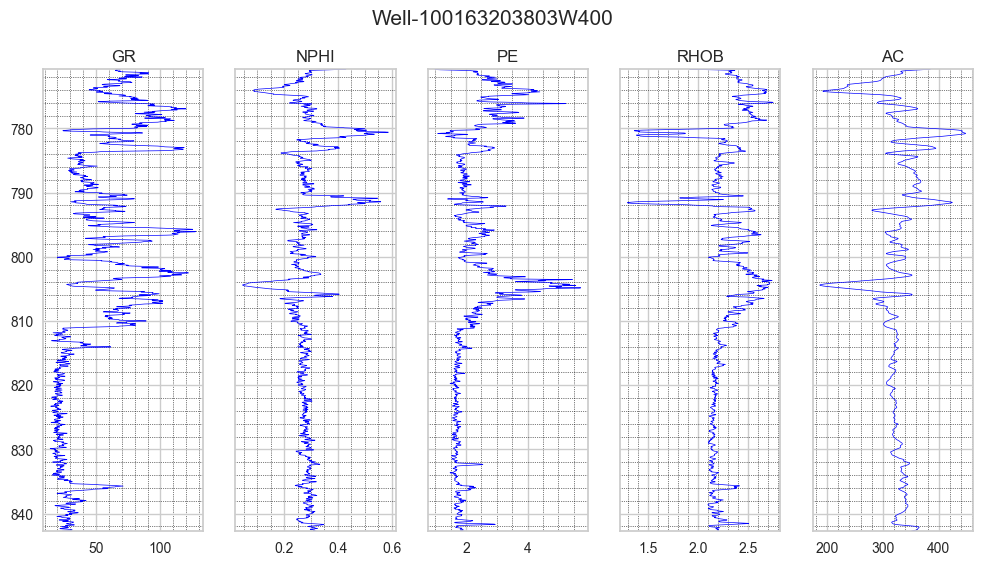

In [153]:
logs = data.columns[1:]
rows,cols = 1,5
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6), sharey=True)

plt.suptitle('Well-100163203803W400', size=15)
for i in range(cols):
    ax[i].plot(data[logs[i]], data.DEPTH, color='blue', lw=0.5)
    ax[i].set_title('%s' % logs[i])
    ax[i].minorticks_on()
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax[i].set_ylim(max(data.DEPTH), min(data.DEPTH))

In [162]:
x = data.iloc[:,1:6]
x.drop('NPHI', inplace=True, axis=1)
x.head(10)

/var/folders/4q/2_vnm84j6hl9mgc_6srxd8_40000gn/T/ipykernel_38176/599775141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop('NPHI', inplace=True, axis=1)


,GR,PE,RHOB,AC
0,68.87,0.99,1.916,384.91
1,68.38,1.00,2.041,376.11
2,65.32,1.16,2.192,366.95
3,65.47,1.50,2.323,358.01
4,66.36,1.92,2.367,349.87
5,65.03,2.13,2.359,342.99
6,66.45,2.20,2.338,337.69
7,68.83,2.33,2.314,334.15
8,67.63,2.38,2.310,332.33
9,67.57,2.29,2.321,331.98


Text(0, 0.5, 'WCSS')

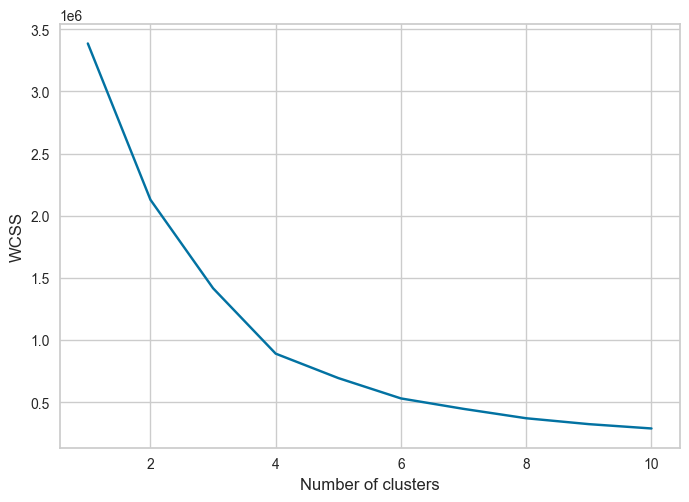

In [20]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state = 42, n_init=10)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 

For 2 clusters,  the average Silhouette score is:  0.4674275647322327
For 3 clusters,  the average Silhouette score is:  0.4988234647027563
For 4 clusters,  the average Silhouette score is:  0.527930219500827
For 5 clusters,  the average Silhouette score is:  0.46541493488967955
For 6 clusters,  the average Silhouette score is:  0.4679141933371511


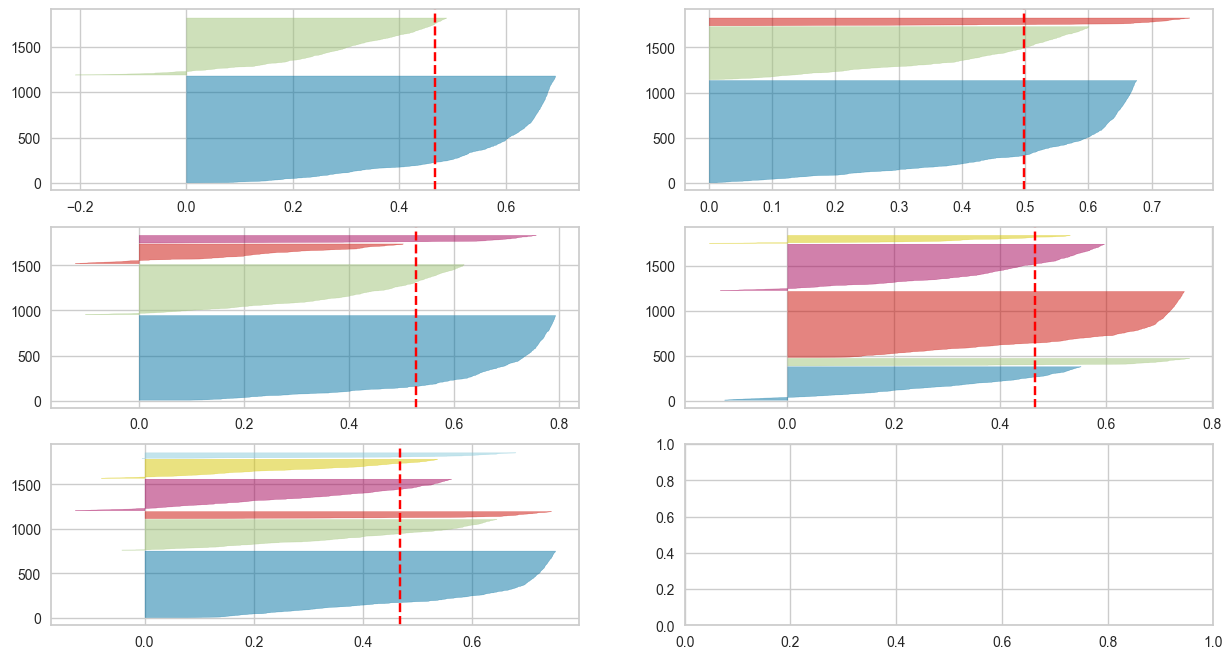

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x) 
    print("For", i, "clusters,  the average Silhouette score is: ", visualizer.silhouette_score_)

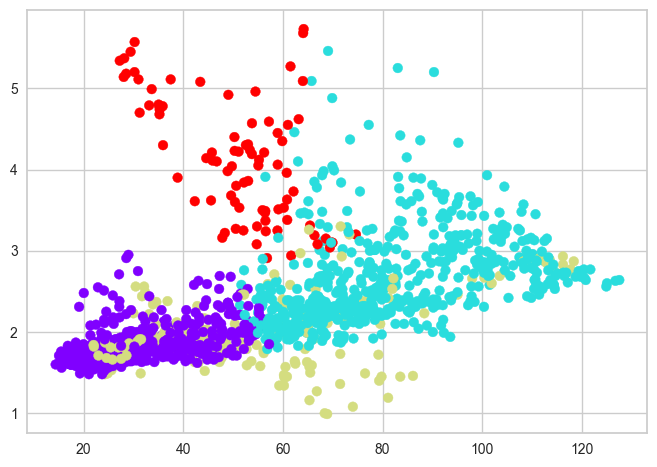

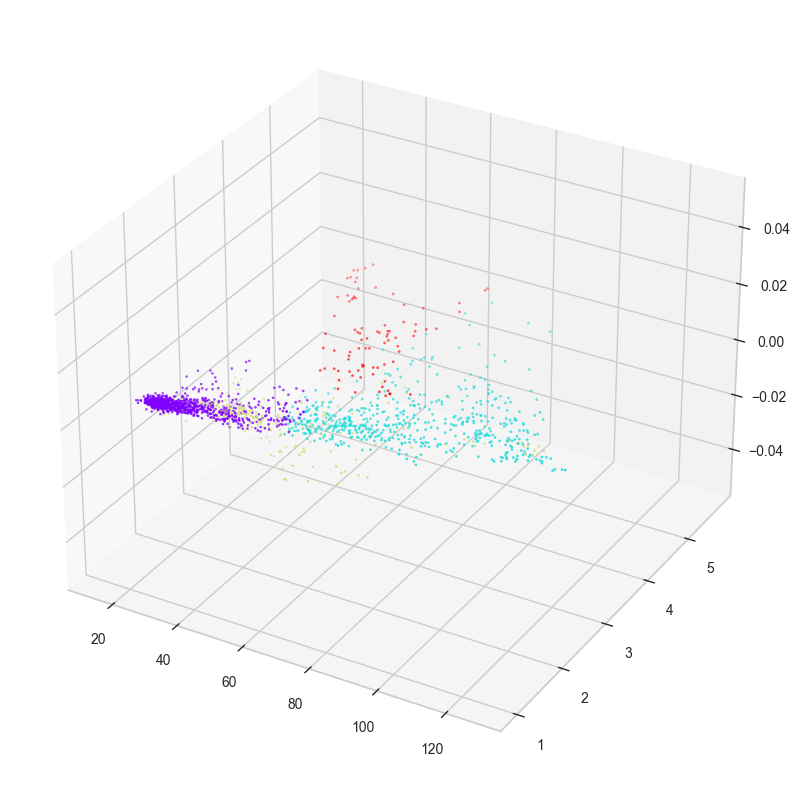

In [158]:
kmeans = KMeans(n_clusters = 4, init = "k-means++", random_state = 42, n_init = 10)
y_kmeans = kmeans.fit_predict(x)
data_with_clusters = data.copy()
data_with_clusters['Clusters'] = y_kmeans 
plt.scatter(data_with_clusters['GR'],data_with_clusters['PE'],c=data_with_clusters['Clusters'],cmap='rainbow')
fig = plt.figure(figsize=(100,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(data_with_clusters['GR'],data_with_clusters['PE'],data_with_clusters['RHOB'],c=data_with_clusters['Clusters'],cmap='rainbow')

In [156]:
output = pd.DataFrame(kmeans.cluster_centers_, columns=['GR', 'PE', 'RHOB', 'AC'])
output = np.round_(output, decimals=2)
output['Lithology'] = None
print('The following are the cluster centers for each cluster:')
output.head()

The following are the cluster centers for each cluster:


,GR,PE,RHOB,AC,Lithology
0,27.35,1.78,2.18,327.35,None
1,81.09,2.67,2.43,318.31,None
2,52.34,1.99,2.05,379.32,None
3,50.85,4.12,2.62,227.70,None


In [157]:
for i in range(0, 4):
    if (output.at[i, 'GR'] > 80):
        output.at[i, 'Lithology'] = 'Shale'
    elif (output.at[i, 'GR'] > 45):
        output.at[i, 'Lithology'] = 'Siltstone'
    elif (output.at[i, 'AC'] < 250):
        output.at[i, 'Lithology'] = 'Limestone'
    elif (output.at[i, 'RHOB'] < 1.8 ):
        output.at[i, 'Lithology'] = 'Coal'
    else:
        output.at[i, 'Lithology'] = 'Sandstone'
print('The following are the cluster centers for each cluster and their interpreted Lithology:')
output.head()

The following are the cluster centers for each cluster and their interpreted Lithology:


,GR,PE,RHOB,AC,Lithology
0,27.35,1.78,2.18,327.35,Sandstone
1,81.09,2.67,2.43,318.31,Shale
2,52.34,1.99,2.05,379.32,Siltstone
3,50.85,4.12,2.62,227.70,Siltstone


In [169]:
labels = pd.DataFrame(kmeans.labels_, columns=['Lithology'])
labels.loc[labels['Lithology'] == 0] = 'Sandstone'
labels.loc[labels['Lithology'] == 1] = 'Shale'
labels.loc[labels['Lithology'] == 2] = 'Siltstone'
labels.loc[labels['Lithology'] == 3] = 'Siltstone'
data['Lithology'] = labels
print('The following are the interpreted Lithology at each Depth value:')
data.head(10)

The following are the interpreted Lithology at each Depth value:


,DEPTH,GR,NPHI,PE,RHOB,AC,Lithology
0,770.80,68.87,0.430,0.99,1.916,384.91,Siltstone
1,770.84,68.38,0.399,1.00,2.041,376.11,Siltstone
2,770.88,65.32,0.358,1.16,2.192,366.95,Siltstone
3,770.92,65.47,0.333,1.50,2.323,358.01,Siltstone
4,770.96,66.36,0.313,1.92,2.367,349.87,Siltstone
5,771.00,65.03,0.298,2.13,2.359,342.99,Shale
6,771.04,66.45,0.293,2.20,2.338,337.69,Shale
7,771.08,68.83,0.298,2.33,2.314,334.15,Shale
8,771.12,67.63,0.295,2.38,2.310,332.33,Shale
9,771.16,67.57,0.296,2.29,2.321,331.98,Shale


In [197]:
lithology_colors  =   { 'Sandstone':    '#D5C2A5',
                        'Coal':    '#191970',
                        'Limestone':    '#6495ED',
                        'Siltstone':    '#CABAAE',
                        'Shale':    '#228B22'  }

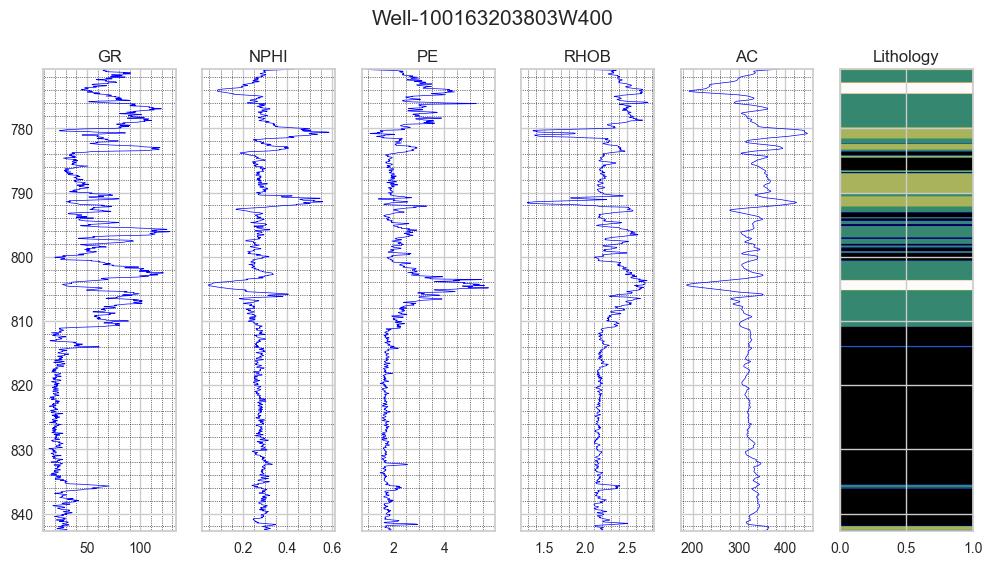

In [217]:
logs = data.columns[1:]
rows,cols = 1,6
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6), sharey=True)

colors = lithology_colors.values()
cmap = ListedColormap(color)
plt.suptitle('Well-100163203803W400', size=15)
for i in range(cols):
    if i < cols-1:
        ax[i].plot(data[logs[i]], data.DEPTH, color='blue', lw=0.5)
        ax[i].set_title('%s' % logs[i])
        ax[i].minorticks_on()
        ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        ax[i].set_ylim(max(data.DEPTH), min(data.DEPTH))
    elif i==cols-1:
        F = np.vstack((kmeans.labels_, kmeans.labels_)).T
        ax[i].imshow(F, aspect='auto', extent=[0,1,max(data.DEPTH), min(data.DEPTH)], cmap='gist_earth')
        ax[i].set_title('Lithology')
